# Pilot - Running Analysis

This Jupyter Notebook is to quickly test feasibility of the things I want to do with this project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import date
from butterworth_distance import get_data#, smooth, distance
from scipy import stats

In [11]:
def distance(data): # returns distance in m
    nextdata = pd.DataFrame([data['lat'], data['lon'], data['time']], ["nextlat", "nextlon","nexttime"])
    nextdata = nextdata.transpose().shift(periods=-1, axis=0)
    data = pd.concat([data, nextdata], axis=1)
    data['time'] = pd.to_datetime(data['time'])
    data['nexttime'] = pd.to_datetime(data['nexttime'])
    data['timediff'] = data['nexttime'] - data['time']
    
    radius=6371000
    lat = radify(data['lat']).astype(np.float64)
    lon = radify(data['lon']).astype(np.float64)
    nextlat = radify(data['nextlat']).astype(np.float64)
    nextlon = radify(data['nextlon']).astype(np.float64)
    
    a = 2*radius
    b = (np.sin((nextlat-lat)/2))**2
    c = np.cos(lat) * np.cos(nextlat) * ((nextlon-lon)/2)**2

    data['distbetween'] = a*np.arcsin(np.sqrt(b+c))
    
    # Want to exclude any pauses (gaps in GPS data longer than 8 seconds)
    # and any slow running (pace greater than 0.67 s/m, same as speed
    # less than 1.5 m/s)
    data['pace'] = data['timediff'] / data['distbetween']
    
    maximumtime = pd.Timedelta(seconds=8)
    maximumpace = pd.Timedelta(seconds=0.67)

    data = data[(data['timediff'] <= maximumtime) | (data['pace'] <= maximumpace)]
    
    totaldistance = pd.DataFrame.sum(data['distbetween'], axis=0)
    return totaldistance

def radify(column):
    return column * np.pi / 180
    
def get_distance(filename):
    points = get_data(filename)
    res = distance(points)
    print('Before filtering: %0.2f' % res)
    points = smooth(points)
    res = distance(points)
    print('After filtering: %0.2f' % res)
    return res

def smooth(data):
    # Return Butterworth-smoothed data
    from scipy import signal
    b, a = signal.butter(3, 0.1)#, btype='lowpass', analog=False)
    lat = signal.filtfilt(b, a, data['lat'])
    lon = signal.filtfilt(b, a, data['lon'])
    low_passed = pd.DataFrame([data['time'], lat, lon], ["time", "lat", "lon"])
    low_passed = low_passed.transpose()
    return low_passed

get_distance('RK_gpx _2017-07-13_1747.gpx')

Before filtering: 4271.63
After filtering: 3734.38


3734.3762259741407

In [12]:
running_data = []
for filename in os.listdir(os.getcwd()):
    if (filename[-4::] == '.gpx'):
        running_data.append(filename)

In [13]:
running_df = pd.DataFrame(data=running_data, columns=['filename'])
running_df['datetime'] = running_df['filename'].str.slice(start=8, stop=23)

In [14]:
# strptime stuff

In [15]:
running_df['datetime'] = pd.to_datetime(running_df['datetime'], format='%Y-%m-%d_%H%M')
def to_timestamp(inputdatetime):
    return inputdatetime.timestamp()
running_df['timestamp'] = running_df['datetime'].apply(to_timestamp)

In [16]:
running_df['distance'] = running_df['filename'].apply(get_distance)

Before filtering: 3407.44
After filtering: 2860.75
Before filtering: 2962.97
After filtering: 2764.17
Before filtering: 4966.72
After filtering: 4691.55
Before filtering: 3127.04
After filtering: 1903.23
Before filtering: 3106.24
After filtering: 2888.65
Before filtering: 5906.20
After filtering: 5703.93
Before filtering: 3865.10
After filtering: 3092.43
Before filtering: 4445.10
After filtering: 4106.12
Before filtering: 4404.16
After filtering: 3671.72
Before filtering: 5285.36
After filtering: 5029.59
Before filtering: 4271.63
After filtering: 3734.38
Before filtering: 4731.11
After filtering: 4165.41
Before filtering: 6180.04
After filtering: 5504.51


In [17]:
fit = stats.linregress(running_df['timestamp'], running_df['distance'])
fit.slope, fit.intercept

(0.00038558204363696766, -573901.5689451088)

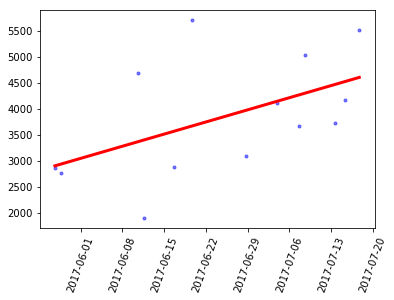

In [18]:
plt.figure()
plt.plot(running_df['datetime'], running_df['distance'], 'b.', alpha = 0.5)
plt.plot(running_df['datetime'], running_df['timestamp']*fit.slope+fit.intercept, 'r-', linewidth=3)
plt.xticks(rotation=70)
plt.show()

In [19]:
print('The p-value is', fit.pvalue)

The p-value is 0.0743784782066
